# TMD maps with one-D potential 

Here we will aim to measure the effect of prefactor reduction in a 1D case of TMD map. Note that our error model is of the form: 

$$ |4L^{(n)}_{\epsilon,\mu}f(x) - \mathcal{L}f(x)| \sim \frac{V(x)\sqrt{\log n}}{\sqrt{n}\epsilon^{2 + d/2}} + \epsilon B(x) $$

Here $V$ and $B$ are variance and bias error prefactors respectively. The 1-D setup is as follows: 

1. $V: \mathbb{R} \to \mathbb{R}$ is a (coercive) potential. 
2. The system $X_t$ is governed by the SDE: 
$\begin{align}dX_t = -\nabla V(X_t) + \sqrt{2\beta^{-1}} dW_t \end{align} $
3. The ergodic measure is $\propto \exp{\left(-\beta V(x)\right)}$
4. The committor satisfies: 
$$\begin{align}\Delta q - \beta\nabla V(x) \cdot \nabla q(x) = 0,\:\: q\mid_{\partial A} = 0\, q\mid_{\partial B} = 1 \end{align}$$

Here $A = [\theta_1-r, \theta_1+r]$ and $B = [\theta_2-r, \theta_2+r]$. The committor function can be given analytically for $x$: 

$$\begin{align}
    q(\theta) = \begin{cases}
        \frac{\int_{\theta_{1}+r}^{\theta}\exp{\left(\beta V(x)\right)}\,dx}{\int_{\theta_{1}+r}^{\theta_{2}-r}\exp{\left(\beta V(x)\right)}\,dx} \quad x \in (\theta_1 + r, \theta_2 - r) \\
        \frac{\int_{\theta}^{\theta_1 - r
        }\exp{\left(\beta V(x)\right)}\,dx}{\int_{\theta_{2}+r}^{\theta_{1}-r}\exp{\left(\beta V(x)\right)}\,dx} \quad x \in (\theta_2 + r, \theta_1 - r) \\
    \end{cases}
\end{align}$$

A good 1-D potential is 

$$ \begin{align}
    V(\theta) = \left(4\cos^2\left(\frac{1}{2}\theta\right)- \frac{3}{2}\right)^2 \label{eq: 1d potential}
\end{align} $$

We set 

$$ \theta_1 = 2\arccos{\left(-\frac{\sqrt{3/2}}{2}\right)} \qquad \theta_1 = 2\arccos{\left(\frac{\sqrt{3/2}}{2}\right)}$$

and $r = 0.4$. 

In [2]:
import os
import copy
import sys 
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__),'..')))
sys.path.append("..")

# Regular Modules
import scipy.sparse as sps
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import time 
from mpl_toolkits.mplot3d import axes3d
import argparse

# parallelization modules 
from math import nan
from joblib import Parallel, delayed
import multiprocess
import itertools
import tqdm

# # My Modules
import src.model_systems as model_systems
import src.helpers as helpers
import src.potentials as potentials
import src.diffusion_map as diffusion_map
from src.fem.distmesh import * 
from src.fem.FEM_TPT import *
import src.sampling as sampling
from datetime import date

How to do this: 

1. Set up drift, potential, invariant measure, committor. 

2. Set up two datasets: uniform, normal random variable centered @ 0. 

3. Set up TMD map kernel for each set. This will involve picking epsilon, N. Don't use knn sparsification. Compare KDE's. 

4. Approximate $\mathcal{L}$ on some simple $f$ (say $f = x^5 - x$) by plugging in the analytical form for $\mathcal{L}f = f'' - V'(x)f'(x)$.

5. Note that $4\mathcal{L}_{\epsilon,\mu}f(x) \approx \mathcal{L}$. DONT FORGET THE FACTOR OF 4!!!

## Define potential, drift

In [3]:
# set up params
beta = 1
d = 1
def potential(x): 
    return (4*(np.cos(x/2))**2 - 3/2)**2

def drift(x): 
    return -4*np.sin(x/2)*np.cos(x/2)*(8*(np.cos(x/2))**2 - 3)

Z = scint.quad(lambda x: np.exp(-beta*potential(x)), 0, 2*np.pi)[0]

def mu(x): return (1/Z)*np.exp(-beta*potential(x))

## Define $\theta,r$

In [4]:
theta_2 = 2*np.arccos(-(np.sqrt(3/2)/2))
theta_1 = 2*np.arccos((np.sqrt(3/2)/2))
r = 0.1

## Define $f$

In [5]:
def f(x): return np.sin(x)
def Lf(x): return -np.sin(x) - beta*drift(x)*np.cos(x)

## Define committor 

In [6]:
Z_committor_12 = scint.quad(lambda x: np.exp(beta*potential(x)), theta_1+r,theta_2-r)[0]
Z_committor_21 = scint.quad(lambda x: np.exp(beta*potential(x)), theta_2+r, 2*np.pi)[0] + \
                 scint.quad(lambda x: np.exp(beta*potential(x)), 0, theta_1-r)[0]

def committor(x):
    # x = 2*np.pi*(x%1.0) # rescale to [0,2pi] interval 
    if 0.0 <= x < theta_1 - r: 
        committor = (1/Z_committor_21)*scint.quad(lambda y: np.exp(beta*potential(y)), x, theta_1 - r)[0]
        return committor 
    elif theta_1-r <= x < theta_1+r:
        return 0.0
    elif theta_1+r <= x < theta_2-r: 
        committor = (1/Z_committor_12)*scint.quad(lambda y: np.exp(beta*potential(y)), theta_1 + r, x)[0]
        return committor 
    elif theta_2-r <= x < theta_2+r: 
        return 1.0
    else: 
        committor = (1/Z_committor_21)*scint.quad(lambda x: np.exp(beta*potential(x)), 0, theta_1-r)[0] + \
                    (1/Z_committor_21)*scint.quad(lambda y: np.exp(beta*potential(y)), x, 2*np.pi)[0]
        return committor 

## Plot the committor 

In [7]:
t = np.linspace(0,2*np.pi,1000)
y = np.zeros(t.shape)
for i in range(t.shape[0]):
    y[i] = committor(t[i])

Text(0, 0.5, 'q(x)')

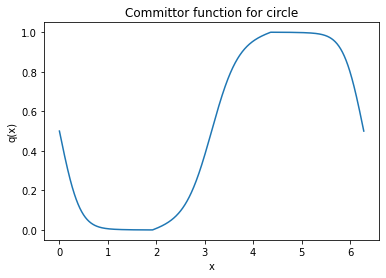

In [8]:
plt.plot(t,y)
plt.title("Committor function for circle")
plt.xlabel("x")
plt.ylabel("q(x)")

## Plot f 

Text(0.5, 1.0, 'Trigonometric function')

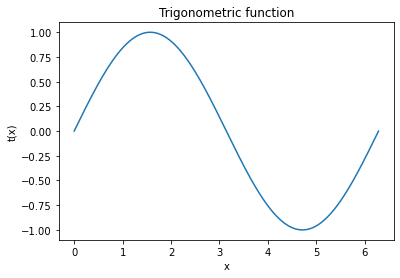

In [9]:
plt.plot(t,f(t))
plt.ylabel("t(x)")
plt.xlabel("x")
plt.title("Trigonometric function")

## Plot the two different densities 

In [13]:
N = int(1e4)
sig = 0.2
biased = 0.6 + sig*np.random.randn(int(N+1)).reshape(N+1,d) # p = biased[N]
biased = 2*np.pi*(biased % 1.0) 
biased[N,0] = np.pi
normal_rnd = (1/(2*np.pi)**(d/2))*np.exp(-((biased-np.pi)**2)/2)

uniform = np.random.uniform(0.0,2*np.pi,N+1).reshape(N+1,d)
uniform[N,0] = np.pi
uniform_rnd = (1/2*np.pi)*np.ones(uniform.shape)

Text(0.5, 0, 'x')

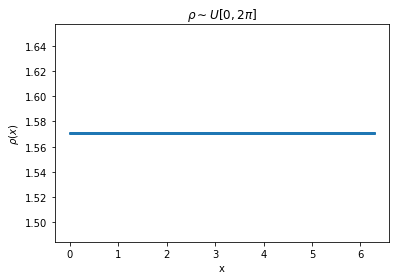

In [14]:
# uniform 

plt.scatter(uniform,uniform_rnd,s=1.0)
plt.title(r"$\rho \sim U[0,2\pi]$")
plt.ylabel(r"$\rho(x)$")
plt.xlabel("x")

Text(0.5, 0, 'x')

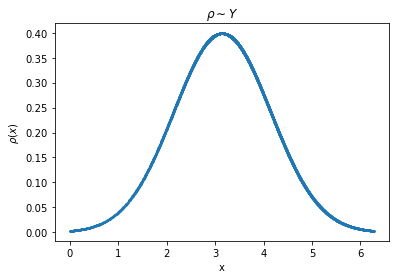

In [15]:
# biased 

plt.scatter(biased,normal_rnd,s=1.0)
plt.title(r"$\rho \sim Y$")
plt.ylabel(r"$\rho(x)$")
plt.xlabel("x")

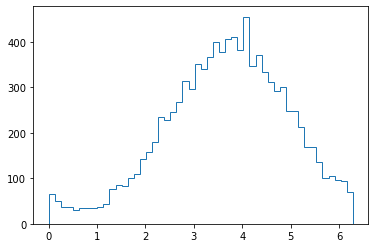

In [16]:
count, bins = np.histogram(biased, bins=50)
plt.stairs(count,bins)

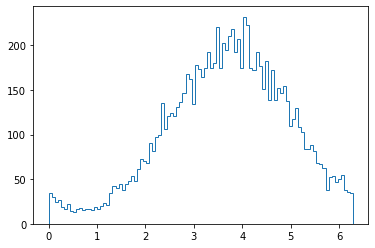

In [17]:
count, bins = np.histogram(biased, bins=100)
plt.stairs(count,bins)

In [18]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [19]:
x = np.cos(bins[:-1])
y = np.sin(bins[:-1])
z = count/np.sum(count)

In [20]:
# Code to convert data in 3D polygons
v = []
h = 0.0 
for k in range(0, len(x)-1):
    xs = [x[k], x[k+1], x[k+1], x[k]]
    ys = [y[k], y[k+1], y[k+1], y[k]]
    zs = [z[k], z[k],       h,     h]
    v.append(list(zip(xs, ys, zs)))    
    #list is necessary in python 3/remove for python 2

k=k+1
xs = [x[k], x[0], x[0], x[k]]
ys = [y[k], y[0], y[0], y[k]]
zs = [z[k], z[k],       h,     h]
v.append(list(zip(xs, ys, zs)))
poly3dCollection = Poly3DCollection(v, alpha=0.4)

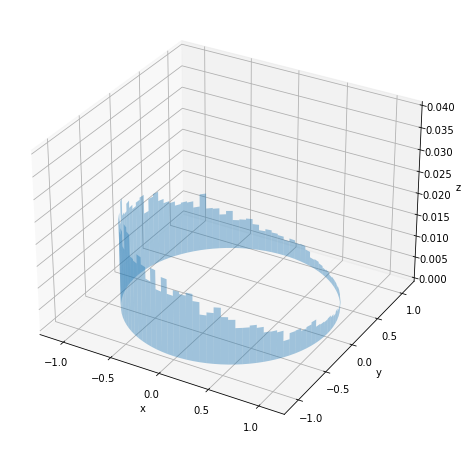

In [21]:
# Code to plot the 3D polygons
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.add_collection3d(poly3dCollection)
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([0.0, 0.04])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

# Diffusion map 

## Uniform

In [92]:
# set up dataset for uniform estimation 
# ϵ_uniform = 1/(10**(4/5))

N = int(1e4)
ϵ_uniform = 2.50*N**(-2/5)
# uniform = np.linspace(-2,2,int(N+1)).reshape(N+1,d) # note that p = uniform[0,N/2]
uniform = np.random.uniform(-0.0,2*np.pi,N+1).reshape(N+1,d)
uniform[N,0] = np.pi

In [93]:
# embed in R^2
data_uniform = np.array([np.cos(uniform), np.sin(uniform)])[:,:,0].T

In [94]:
# Tmd map set up 

target_measure_uniform = np.zeros(N+1)

for i in range(N+1):
    target_measure_uniform[i] = mu(uniform[i,:])

target_dmap_uniform = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ_uniform, n_neigh=int(N), \
                                                          target_measure=target_measure_uniform)
target_dmap_uniform.construct_generator(data_uniform.T)
K_uniform = target_dmap_uniform.get_kernel()
# inds = np.where(np.abs(uniform) <= 3)[0]
L_uniform = target_dmap_uniform.get_generator() 
# L_uniform = construct_L(ϵ_uniform, target_measure_uniform, K_uniform, inds)

## Biased 

In [26]:
N = int(1e4)
# ϵ_biased = 1/(10**(4/5))
ϵ_biased = N**(-2/5)
sig = 0.1
biased = 0.6 + sig*np.random.randn(int(N+1)).reshape(N+1,d) # p = biased[N]
biased = 2*np.pi*(np.abs(biased) % 1.0) 
biased[N,0] = np.pi

In [27]:
# embed in R^2 
data_biased = np.array([np.cos(biased), np.sin(biased)])[:,:,0].T

In [28]:
# set up dataset for biased estimation 

target_measure_biased = np.zeros(N+1)
for i in range(N+1):
    target_measure_biased[i] = mu(biased[i,:])

target_dmap_biased = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ_biased, n_neigh=int(N), \
                                                          target_measure=target_measure_biased)
target_dmap_biased.construct_generator(data_biased.T)
K_biased = target_dmap_biased.get_kernel()
L_biased = target_dmap_biased.get_generator() 

# Testing on pointwise estimates

## Uniform 

In [95]:
# derivative on uniform set 
# F_uniform = f(uniform)
# LF_uniform_true = Lf(uniform)
# LF_uniform_TMD = L_uniform@F_uniform 
F_uniform = np.apply_along_axis(f,1,uniform)
LF_uniform_true = np.apply_along_axis(Lf, 1, uniform)
LF_uniform_TMD = L_uniform@F_uniform

(0.0, 1.0)

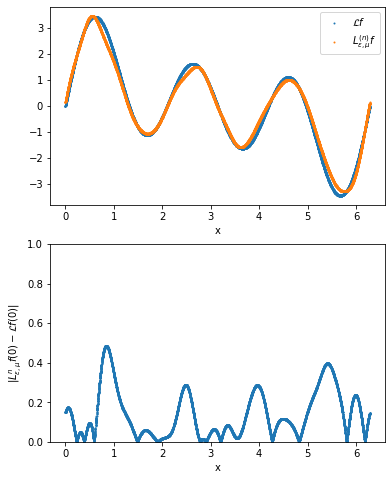

In [96]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
ax1.scatter(uniform, LF_uniform_true, s=1.0, label="$\mathcal{L}f$")
ax1.scatter(uniform, 4*(1/beta)*LF_uniform_TMD, s=1.0, label="$L^{(n)}_{\epsilon,\mu}f$")
# ax1.set_xlim((-0.5,0.5))
# ax1.set_ylim((-100,100))
ax1.set(xlabel="x")
ax1.legend()
ax2.scatter(uniform, np.abs(LF_uniform_true-4*(1/beta)*LF_uniform_TMD), s=1.0)
ax2.set(xlabel="x", ylabel="$|L^{n}_{\epsilon,\mu}f(0) - \mathcal{L}f(0)|$")
#ax2.set_xlim((-0.5,0.5))
ax2.set_ylim((0.0,1.0))

In [97]:
# check committor on uniform set 
committor_uniform = np.apply_along_axis(committor, 1, uniform)
# LF_uniform_true = Lf(uniform)
Lcommittor_uniform_TMD = L_uniform@committor_uniform 

(-0.1, 0.1)

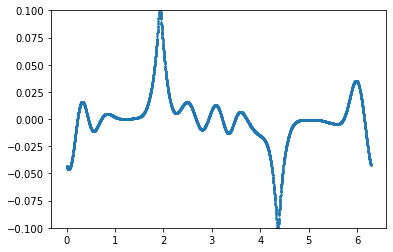

In [98]:
fig, ax1 = plt.subplots()
# ax1.scatter(uniform, LF_uniform_true, s=1.0)
ax1.scatter(uniform, Lcommittor_uniform_TMD, s=1.0)
# ax1.set_xlim((-0.9,0.9))
ax1.set_ylim((-0.1,0.1))
# ax2.scatter(uniform, np.abs(LF_uniform_true-4*LF_uniform_TMD), s=1.0)
# ax2.set_xlim((-0.5,0.5))
# ax2.set_ylim((0.0, 10.0))

In [99]:
# checking KDE 
rho_epsilon_uniform = (1/(N+1))*(1/(np.pi*ϵ_uniform)**(d/2))*K_uniform@np.ones((N+1,1))

In [100]:
uniform_rnd = (1/(2*np.pi))*np.ones(uniform.shape)

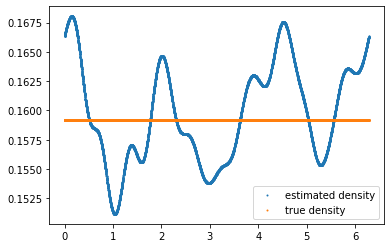

In [101]:
plt.scatter(uniform, rho_epsilon_uniform, s=1.0, label="estimated density")
plt.scatter(uniform, uniform_rnd, s=1.0, label="true density")
# plt.ylim((0.20,0.30))
# plt.xlim((-1.5,1.5))
plt.legend()

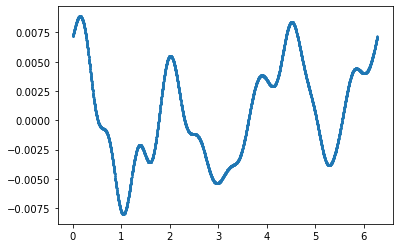

In [102]:
plt.scatter(uniform, rho_epsilon_uniform-uniform_rnd, s=1.0)
#plt.ylim((-0.01,0.015))

## Biased

In [103]:
# derivative on biased set 
# F_biased = f(biased)
# LF_biased_true = Lf(biased)
# LF_biased_TMD = L_biased@F_biased
F_biased = np.apply_along_axis(f,1,biased)
LF_biased_true = np.apply_along_axis(Lf, 1, biased)
LF_biased_TMD = L_biased@F_biased

(0.0, 0.6)

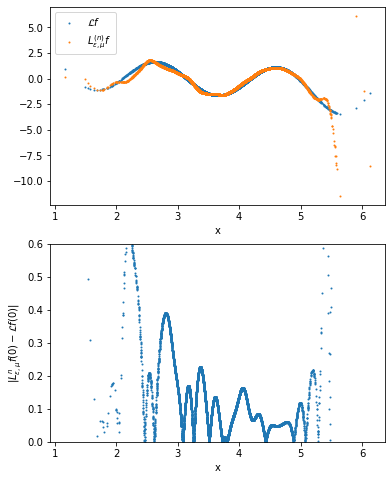

In [104]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
ax1.scatter(biased, LF_biased_true, s=1.0, label="$\mathcal{L}f$")
ax1.scatter(biased, 4*(1/beta)*LF_biased_TMD, s=1.0, label="$L^{(n)}_{\epsilon,\mu}f$")
# ax1.set_xlim((-2.0,2.0))
# ax1.set_ylim((-100,100))
ax1.set(xlabel="x")
ax1.legend()
ax2.scatter(biased, np.abs(LF_biased_true-4*(1/beta)*LF_biased_TMD), s=1.0)
ax2.set(xlabel="x", ylabel="$|L^{n}_{\epsilon,\mu}f(0) - \mathcal{L}f(0)|$")
# ax2.set_xlim((-2.0,2.0))
ax2.set_ylim((0,0.6))

In [89]:
# check committor on uniform set 
committor_biased = np.apply_along_axis(committor, 1, biased)
# LF_uniform_true = Lf(uniform)
Lcommittor_biased_TMD = L_biased@committor_biased

(0.0, 0.1)

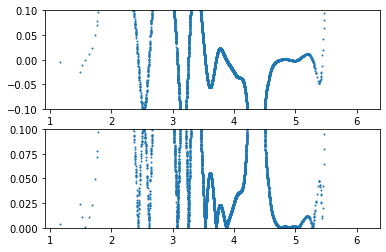

In [109]:
fig, (ax1,ax2) = plt.subplots(2,1)
# ax1.scatter(uniform, LF_uniform_true, s=1.0)
ax1.scatter(biased, 4*(1/beta)*Lcommittor_biased_TMD, s=1.0)
#ax1.set_xlim((-0.45,0.45))
ax1.set_ylim((-0.1,0.1))
ax2.scatter(biased, np.abs(4*(1/beta)*Lcommittor_biased_TMD), s=1.0)
ax2.set_ylim((0.0,0.1))

In [178]:
# checking KDE 
rho_epsilon_biased = (1/(N+1))*(1/(np.pi*ϵ_biased)**(d/2))*K_biased@np.ones((N+1,1))

In [43]:
# normal_rnd = (1/(2*np.pi)**(d/2))*np.exp(-(biased**2)/2)

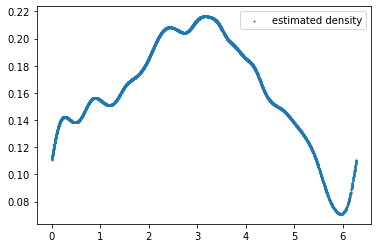

In [179]:
plt.scatter(biased, rho_epsilon_biased, s=1.0, label="estimated density")
# plt.scatter(biased, normal_rnd, s=1.0, label="true density")
plt.legend()

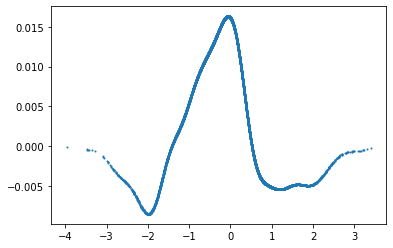

In [28]:
plt.scatter(biased, normal_rnd-rho_epsilon_biased, s=1.0)

Scaling law seems to be 2 + d/2! 

# Testing bias error 

Main idea: For each uniform/biased dataset do the following. Have a range of epsilons, and pick N according to the 1/2 + 0.5d scaling law. Then approximate f with the TMD map generator and compare error according to epsilon. Inshallah everything should lineup roughly along a line. 

## Uniform

In [212]:
# set up info 
# epsilons = np.linspace(0.04, 0.06, 10)  # actual sim 
epsilons = np.linspace(0.06, 0.07, 2)     # trial params for debug 
Ns_uniform = epsilons**(-3)
epsilons_range = len(epsilons)
# ntrials = 12 # actual sim 
ntrials = 3    # trial params for debug 
trial_ids = np.linspace(1,ntrials,ntrials)
Lcommittor_uniform_TMD = np.zeros((epsilons_range, ntrials))

In [209]:
def task(t, regime="uniform"):
    # ϵ_uniform = epsilons_uniform[i]
    np.random.seed() 
    ϵ, _  = t
    N = int(ϵ**(-3))
    # print(N)
    
    if regime=="uniform":
        data = np.random.uniform(0.0,2*np.pi,N+1).reshape(N+1,d)        
    else:
        sig = 0.1
        data = 0.5 + sig*np.random.randn(int(N+1)).reshape(N+1,d) # p = biased[N]
        data = 2*np.pi*(np.abs(biased) % 1.0) 
        
    data[N,0] = np.pi
    data_embedded = np.array([np.cos(data), np.sin(data)])[:,:,0].T

    target_measure = np.zeros(N+1)

    for i in range(N+1):
        target_measure[i] = mu(data[i,:])

    target_dmap = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ, n_neigh=int(N), \
                                                              target_measure=target_measure)
    target_dmap.construct_generator(data_embedded.T)
    # print("Got kernel!")
    K = target_dmap.get_kernel()
    L = target_dmap.get_generator() 
    # check committor on uniform set 
    committor_data = np.apply_along_axis(committor, 1, data)
    # LF_uniform_true = Lf(uniform)
    # print(L.shape)
    # print(committor_data.shape)
    Lcommittor_atzero = L[-1,:]@committor_data
    print("Got result!")
    return Lcommittor_atzero[0]

In [196]:
# full parallel
args = list(itertools.product(*[epsilons, trial_ids])) 
# create iterable for multiprocess
# def task_unif(t): return task(t, regime="uniform")
# with multiprocess.Pool(multiprocess.cpu_count()) as pool:
#     result = pool.map(task_unif, args)

In [213]:
# half parallel
for i in tqdm.tqdm(range(epsilons_range)):
    print("Starting new epsilon...")
    ϵ = epsilons[i]
    def task_sub(x): return task([ϵ,x], regime="biased")
    with multiprocess.Pool(multiprocess.cpu_count()) as pool: 
        result = pool.map(task_sub, list(trial_ids))
    Lcommittor_uniform_TMD[i,:] = np.array(result)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Starting new epsilon...
Got result!
Got result!
Got result!


 50%|██████████████████████▌                      | 1/2 [00:22<00:22, 22.41s/it]

Starting new epsilon...
Got result!Got result!

Got result!


100%|█████████████████████████████████████████████| 2/2 [00:35<00:00, 17.86s/it]


In [215]:
# no parallel 
for i in tqdm.tqdm(range(epsilons_range)):
    ϵ = epsilons[i]
    def task_sub(x): return task([ϵ,x], regime="uniform")
    for j in tqdm.tqdm(range(ntrials)):
        Lcommittor_uniform_TMD[i,j] = task_sub(trial_ids[j])

 33%|███████████████                              | 1/3 [00:04<00:09,  4.96s/it]

Got result!



 67%|██████████████████████████████               | 2/3 [00:09<00:04,  4.46s/it]

Got result!



 50%|██████████████████████▌                      | 1/2 [00:13<00:13, 13.06s/it]

Got result!



 33%|███████████████                              | 1/3 [00:01<00:02,  1.41s/it]

Got result!



 67%|██████████████████████████████               | 2/3 [00:02<00:01,  1.41s/it]

Got result!



100%|█████████████████████████████████████████████| 2/2 [00:17<00:00,  8.65s/it]

Got result!


# Load generated data

## Testing bias error

In [2]:
data = np.load('uniform_committor_circular_2023-07-06 13:48:50.043468.npy', allow_pickle=True)

In [3]:
# run this for second gen dataset 
epsilons = data.item()['epsilons']
bias = data.item()['pointwise_errors']
epsilons_range, ntrials = bias.shape

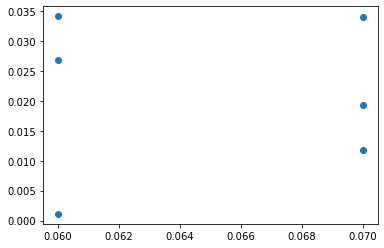

In [4]:
plt.scatter(epsilons.reshape((epsilons_range,1))@np.ones((1,ntrials)), np.abs(bias))

In [103]:
# fit linear model
x = epsilons.reshape((epsilons_range,1))@np.ones((1,ntrials))
linear_fit = sklearn.linear_model.LinearRegression()
linear_fit.fit(x.reshape(-1,1), np.abs(bias).reshape(-1,1))
y = linear_fit.predict(epsilons.reshape(-1,1))

In [104]:
# compute RMSE 
RMSE = np.sqrt(np.mean((y.reshape((epsilons_range,1))@np.ones((1,ntrials)) - np.abs(bias))**2, axis=1)).reshape(y.shape)
y_low = y-RMSE
y_high = y+RMSE

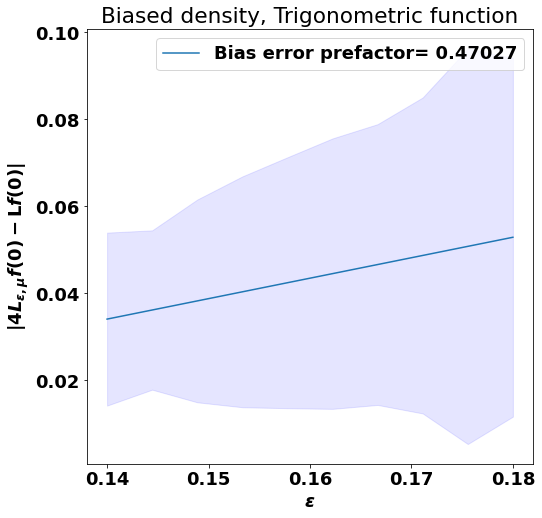

In [105]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
fig, ax = plt.subplots(figsize=(8,8))
# p1 = ax.scatter(x,np.abs(bias), alpha=0.2,label="Bias error prefactor= " + str(round(linear_fit.coef_[0,0],5)))
p2 = ax.plot(epsilons,y,label="Bias error prefactor= " + str(round(linear_fit.coef_[0,0],5)))
p1 = ax.fill_between(epsilons,y_low.flatten(), y_high.flatten(), color = 'blue', alpha=0.1)
# ax.set(ylim=(0.0,0.04))
ax.set(ylabel = r'$|4L_{\epsilon,\mu}f(0) - \mathbf{L} f(0)|$', xlabel = "$\epsilon$");
ax.set(title="Biased density, Trigonometric function")
ax.legend(loc = 'best')
fig.savefig("Biased + Trigpoly", bbox_inches="tight")

## Testing error model

In [147]:
data = np.load('uniform_committor_fixedN_2023-04-29 10:22:24.271316.npy', allow_pickle=True)

In [148]:
bias = data.item()['pointwise_errors']
epsilons = data.item()['epsilons']

In [149]:
epsilons

array([1.52587891e-05, 2.17718045e-05, 3.10648158e-05, 4.43244280e-05,
       6.32437330e-05, 9.02384970e-05, 1.28755625e-04, 1.83713287e-04,
       2.62128911e-04, 3.74015224e-04, 5.33658753e-04, 7.61444043e-04,
       1.08645652e-03, 1.55019634e-03, 2.21187746e-03, 3.15598856e-03,
       4.50308119e-03, 6.42516277e-03, 9.16765984e-03, 1.30807561e-02,
       1.86641065e-02, 2.66306374e-02, 3.79975782e-02, 5.42163498e-02,
       7.73578928e-02, 1.10377102e-01, 1.57490131e-01, 2.24712743e-01,
       3.20628452e-01, 4.57484532e-01, 6.52755849e-01, 9.31376184e-01,
       1.32892198e+00, 1.89615503e+00, 2.70550412e+00, 3.86031332e+00,
       5.50803780e+00, 7.85907203e+00, 1.12136146e+01, 1.60000000e+01])

In [150]:
bias = bias[epsilons <= 1.0, :]
epsilons = epsilons[epsilons <= 1.0]
epsilons_range, ntrials = bias.shape

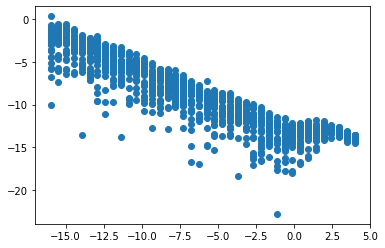

In [151]:
fig, ax = plt.subplots()
ax.scatter(np.log2(epsilons.reshape((epsilons_range,1))@np.ones((1,ntrials))), \
           np.log2(np.abs(bias)))
# ax.scatter(np.log2(epsilons), np.log2(np.mean(np.abs(bias), axis=1)))
# ax.set_xscale('log')
# ax.set_yscale('log')


In [152]:
# fit linear model
noisy = True

if noisy:
    # noisy data
    x = epsilons.reshape((epsilons_range,1))@np.ones((1,ntrials))
    y_noisy = np.abs(bias)
else:
    # averaged data
    x = epsilons
    y_noisy = np.mean(np.abs(bias), axis=1)

linear_fit = sklearn.linear_model.LinearRegression()
linear_fit.fit(np.log2(x).reshape(-1,1), \
               np.log2(y_noisy).reshape(-1,1))
y = linear_fit.predict(np.log2(epsilons).reshape(-1,1))

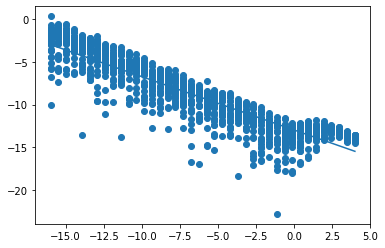

In [153]:
# visualize linear model 
fig, ax = plt.subplots()
ax.scatter(np.log2(x), np.log2(y_noisy))
ax.plot(np.log2(epsilons),y)

In [154]:
linear_fit.coef_

array([[-0.62621669]])